In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open("names.txt", "r").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:1+i for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {s:i for i,s in stoi.items()}
vocab_size = len(itos)
vocab_size

27

In [7]:
# build the dataset 
block_size = 3 # context length

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [29]:
# MLP Revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd))
W1 = torch.randn((n_embd * block_size, n_hidden)) *.1
b1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn((n_hidden, vocab_size)) * 0.01
b2 = torch.randn(27) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
    
sum(p.nelement() for p in parameters) # total number of parameters

11897

In [19]:
# we should expect that at initialization, this is our loss
-torch.tensor(1/27.0).log()

tensor(3.2958)

Some notes:
The initialization of our network is messed up... we start at 27 which is way too high...
1. Softmax is confidently wrong
2. tanh layer is too saturated at init

In [31]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # forward pass
    emb = C[Xtr[ix]] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Ytr[ix]) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')

    lossi.append(loss.log10().item())

      0/ 200000: 3.282933
  10000/ 200000: 2.195356
  20000/ 200000: 1.749732
  30000/ 200000: 2.120897
  40000/ 200000: 2.079607
  50000/ 200000: 2.587304
  60000/ 200000: 1.661591
  70000/ 200000: 1.979592
  80000/ 200000: 2.234456
  90000/ 200000: 2.211609
 100000/ 200000: 2.324115
 110000/ 200000: 1.852239
 120000/ 200000: 2.216318
 130000/ 200000: 1.963404
 140000/ 200000: 2.058832
 150000/ 200000: 2.064464
 160000/ 200000: 2.538999
 170000/ 200000: 1.869335
 180000/ 200000: 2.076940
 190000/ 200000: 2.181247


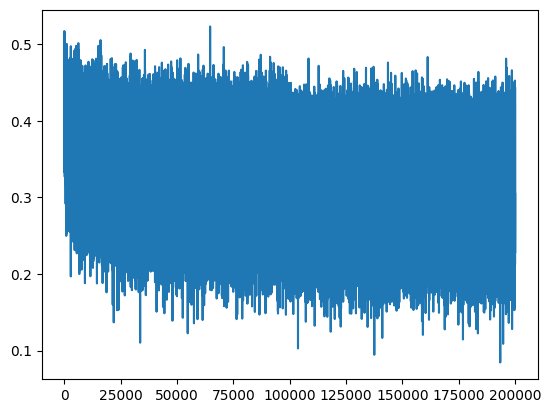

In [32]:
plt.plot(lossi)

Note: torch.no_grad() will let torch know that it doesn't have to keep track of any of the gradients within the function. This means that it will not do any of the bookkeeping that it would do in anticipation of a backwards pass. Makes everything much more efficient.

In [33]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.055330276489258
val 2.113402843475342


In [34]:
# sample from the model
block_size = 3
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        enb = C[torch.tensor([context])]
        h = torch.tanh(enb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

yazar.
aakdier.
andrik.
mylaan.
anhenaviden.
arilla.
liyah.
nith.
leocia.
gramoren.
wurdani.
fay.
drahrister.
cornne.
malan.
ari.
deira.
jeni.
prieleggonnalia.
and.
